### Notebook is a modified copy of modelling/Dennis_CNN3.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from scipy import stats

In [2]:
from preprocessing.getdata import *

# load csv_file
df = get_csvdata()

#split dataframe into train and test
dfTrain, dfTest, y_train, y_test = train_test_split(df, df['CDR'], stratify = df['CDR'], random_state=42)
training_history= {}

In [12]:
# load image data (N slices above and below the plane (m), suggested by the datasource)
# standard values for m are 95 for dim=0, 90 for dim=1, 110 for dim=2
N, d, m, dim = 10, 2, 90, 2
X_train = get_slices(dfTrain['ID'], N=N, d=d, m=m, dim=dim,)

#load only single slices for test data to simulate a situation when only these slices are available and not the whole 3D image

Ntest=5
X_test = get_slices(dfTest['ID'], m=m, dim=dim, N=Ntest) 

#expand y_train to the same length as X_train
y_train = y_train.repeat(1+2*N) 


In [13]:
HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]

In [14]:
model = Sequential()

# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))



In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 176, 208, 8)       80        
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 208, 8)       584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 88, 104, 8)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 88, 104, 16)       1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 104, 16)       2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 44, 52, 16)       0         
 2D)                                                  

In [16]:
training_history[f"N,d,m,dim,Ntest={N},{d},{m},{dim},{Ntest}"] = model.fit(X_train, y_train, batch_size = 32, validation_split=0.2, epochs = 20)

Epoch 1/20


2022-08-22 14:11:19.744736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 8.3360 - accuracy: 0.5836

2022-08-22 14:11:29.588078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 12s 138ms/step - loss: 8.3360 - accuracy: 0.5836 - val_loss: 1.4367 - val_accuracy: 0.9948
Epoch 2/20
72/72 [==============================] - 8s 104ms/step - loss: 1.4836 - accuracy: 0.6848 - val_loss: 1.1919 - val_accuracy: 0.9108
Epoch 3/20
72/72 [==============================] - 7s 99ms/step - loss: 1.2696 - accuracy: 0.7771 - val_loss: 1.1120 - val_accuracy: 0.8916
Epoch 4/20
72/72 [==============================] - 9s 121ms/step - loss: 1.0732 - accuracy: 0.8520 - val_loss: 1.7977 - val_accuracy: 0.4685
Epoch 5/20
72/72 [==============================] - 8s 108ms/step - loss: 0.9335 - accuracy: 0.8945 - val_loss: 1.8655 - val_accuracy: 0.4528
Epoch 6/20
72/72 [==============================] - 9s 125ms/step - loss: 0.8487 - accuracy: 0.9168 - val_loss: 2.0299 - val_accuracy: 0.4808
Epoch 7/20
72/72 [==============================] - 7s 104ms/step - loss: 0.7418 - accuracy: 0.9483 - val_loss: 2.0775 - val_accuracy: 0.4650
Epoch 8/20
72/72 

In [17]:
# prediction of outcomes and conversion to binary
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs>0.5).astype(int)



2022-08-22 14:13:50.279747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
X_train.shape

(2856, 176, 208)

In [21]:
# reshape is necessary if X_test also consists of multiple slices per sample

if Ntest != 0:
    test_length, slices_per_test_sample = dfTest.shape[0], int(y_pred.shape[0]/dfTest.shape[0])

    l = []
    for i in range(test_length):
        for j in np.where(y_pred.reshape((test_length,slices_per_test_sample))[i]==y_test.values[i])[0]:
            l.append(j)
        
    for i in range(slices_per_test_sample+1):
        print(i, l.count(i))

    y_pred = np.array(stats.mode(y_pred.reshape((test_length,slices_per_test_sample)), axis=1, keepdims=False))[0]

0 24
1 26
2 24
3 25
4 29
5 24
6 29
7 23
8 27
9 23
10 28
11 0


accuracy:  0.57
recall:  0.43
precision:  0.59


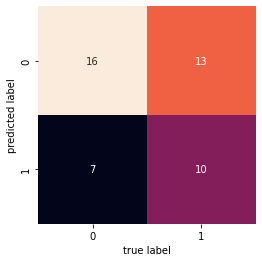

In [22]:
accuracy_score(y_test, y_pred)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

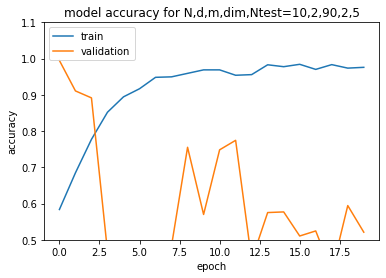

In [23]:
# summarize history for accuracy
plt.plot(training_history[f"N,d,m,dim,Ntest={N},{d},{m},{dim},{Ntest}"].history['accuracy'])
plt.plot(training_history[f"N,d,m,dim,Ntest={N},{d},{m},{dim},{Ntest}"].history['val_accuracy'])
plt.title(f"model accuracy for N,d,m,dim,Ntest={N},{d},{m},{dim},{Ntest}")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.5,1.1])
plt.show()

In [30]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

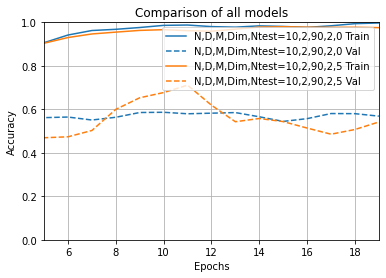

In [33]:
# Instantiate HistoryPlotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

# Plot results of all models
plotter.plot(training_history)
plt.xlim([5, max(plt.xlim())])
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.title('Comparison of all models')
plt.legend(loc='upper right');